# Forecasting of Retail Sales:

One our cousins in the spanish country have a grocery stores company which works in some villages in La Mancha. He have heard in the news something about the Machine Learning and its posibilities. Since he knows that we work as Data Scientist he has porpuse us to see if we can make a prediction in one of their products and we have accepted the offer. 

Our idea is to apply a couple of ML models and chechk if we can give him a good prediction of the sales of one of his products.

In [576]:
import pandas as pd # General imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.svm import SVR # Explicit imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

# from model_evaluation import calculoEvaluacionModelo # Fail in the import, does not recognize numpy.

fig_size = (29, 12) # Macrovariables
norma = False

In [577]:
# The function we have defined in the model_evaluation file:

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(759,829):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted= xPredicted + [day]
        yPredicted= yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p) 
        print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sales predicted': yPredicted,
         'Actual Sales': ySpotted
        },index=xPredicted)

    prediction.plot(figsize = fig_size, color = {'Sales predicted':'lime', 'Actual Sales':'forestgreen'})

In [578]:
df = pd.read_csv('Dataframe_Retail.csv', parse_dates=['Fecha'])
df.head(10)

,Fecha,Referencia,Unidades,Ventas
0,2017-01-01,Cerveza tercio,18.000000,11.700000
1,2017-01-01,Baguetes 2 unidades,34.000000,33.320001
2,2017-01-02,Aceite de oliva virgen extra 5 l,53.000000,1184.550020
3,2017-01-02,Bolsa naranjas 2Kg.,1118.000000,1889.420064
4,2017-01-02,Mandarina,1752.468997,3356.279999
5,2017-01-02,Melo OR,399.428999,728.429999
6,2017-01-02,Baguetes 2 unidades,3572.000000,3257.839944
7,2017-01-02,Jamón reserva,48.515000,870.689999
8,2017-01-02,Cerveza tercio,1280.000000,802.150005
9,2017-01-02,Naranja en cajas,831.050001,1470.350000


## Data Analysis

What we can find in the dataframe is the sells of the each product each day and the money earned by the sale.

In [579]:
df['Referencia'].unique(), df['Referencia'].unique().shape

(array(['Cerveza tercio', 'Baguetes 2 unidades',
        'Aceite de oliva virgen extra 5 l', 'Bolsa naranjas 2Kg.',
        'Mandarina', 'Melo  OR', 'Jamón reserva', 'Naranja en cajas',
        'Pack de plátanos', 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)',
        'Tomate jugoso al peso', 'Filetes de salmón', 'Sepia',
        'Fresa premium 500gr'], dtype=object),
 (14,))

* We have fourteen different products that the grocery store have in sales, so we will choose one in order to make the prediction. As good spaniards we choose iberian jam (_"Jamón reserva"_). As we can see this parameter is a float64, so the ham can be sold not for units (kg for the ham) but also fractions of the units.

In [580]:
df = df.loc[df['Referencia'] == 'Jamón reserva'].\
    drop('Referencia', axis = 1).\
    set_index('Fecha')

In [581]:
df.head()

,Unidades,Ventas
Fecha,,
2017-01-02,48.515,870.689999
2017-01-03,63.325,1136.559994
2017-01-04,42.230,922.829997
2017-01-05,58.165,1273.139998
2017-01-07,71.330,1561.350001


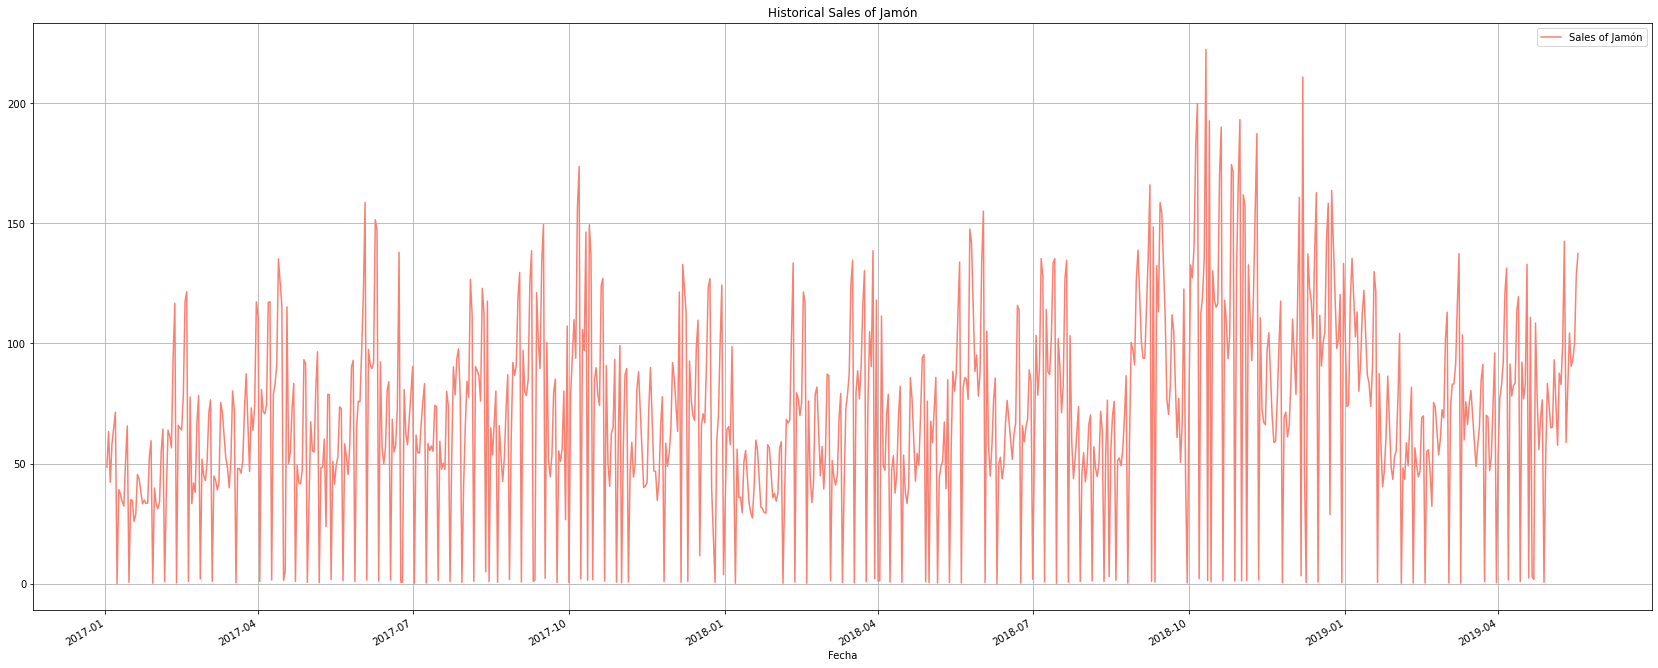

In [582]:
df['Unidades'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Historical Sales of Jamón');

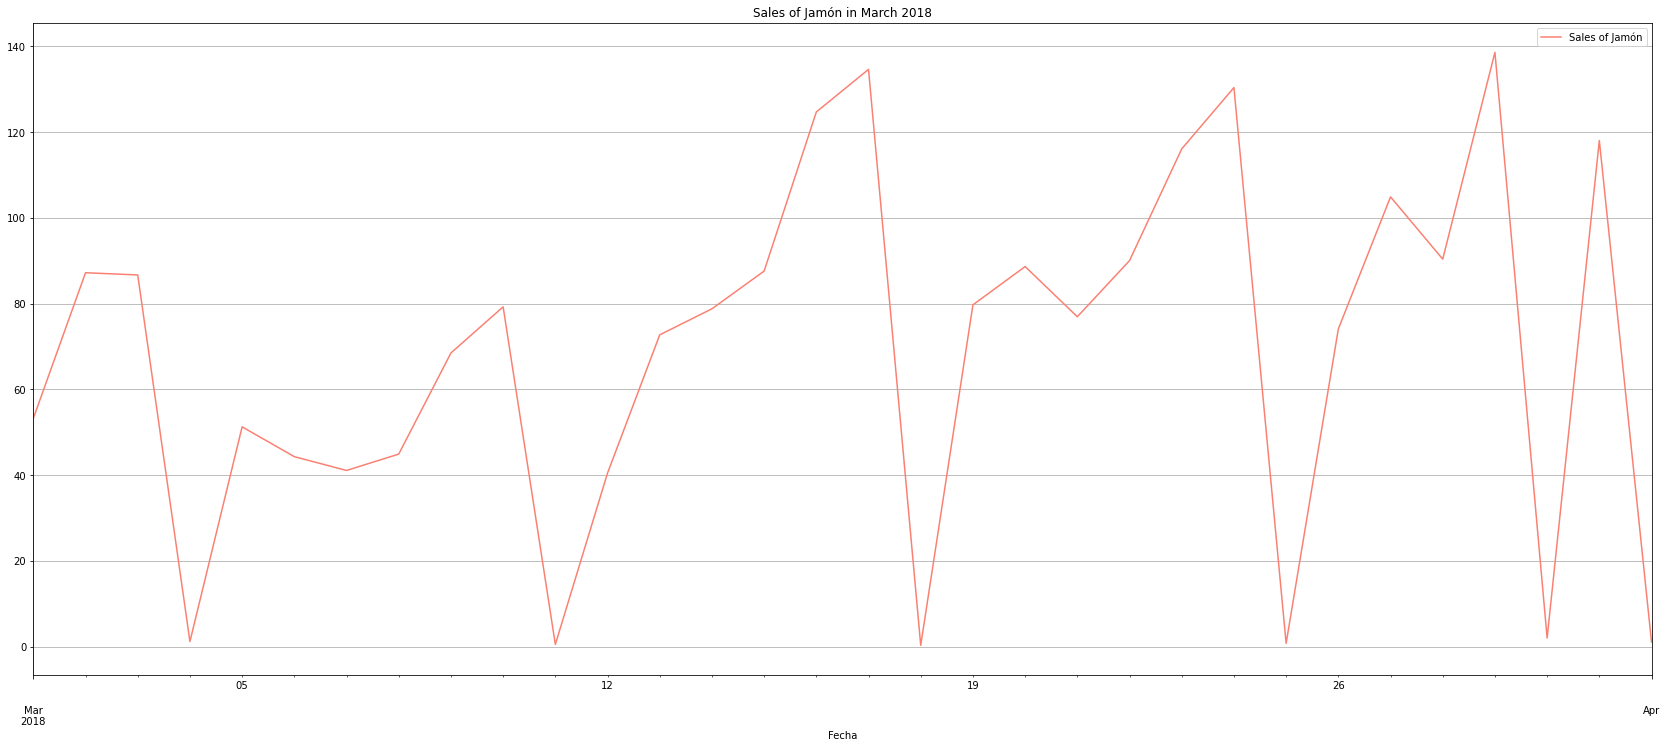

In [583]:
df['Unidades']['2018-03-01':'2018-04-01'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón in March 2018');

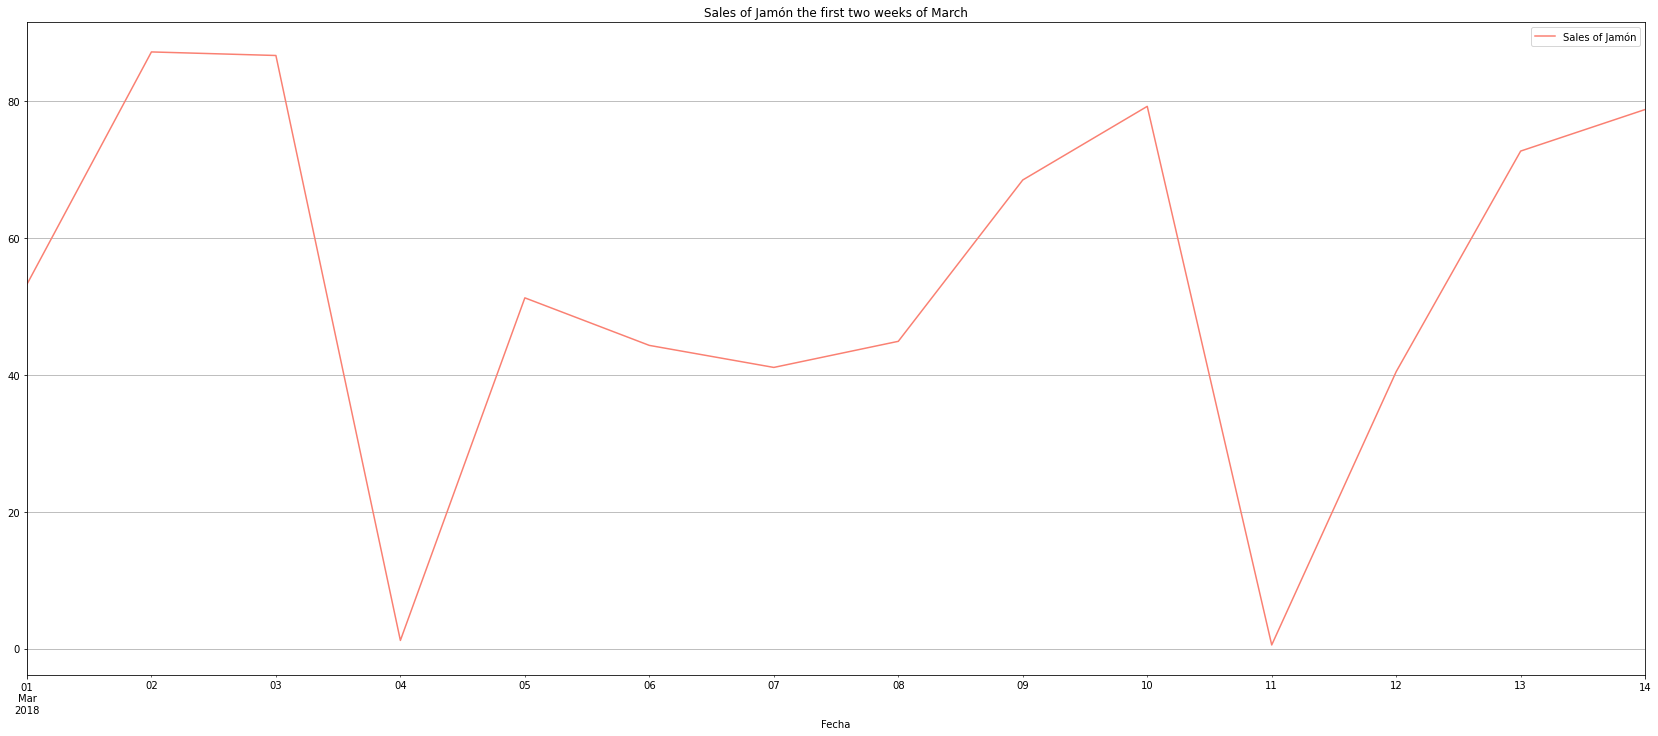

In [584]:
df['Unidades']['2018-03-01':'2018-03-14'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón the first two weeks of March'); # We can see how we have some stationality at week level. March 4th and March 11th were both Sunday.

## Featuring Engineer:

We now will create artificial parameters in the data in order to make it more clear to the model. In this case we will take in account the day of the week of the sale by one-hot-enconding techniques and by shifting the sales we will also add information of the units sold last week.

In [585]:
df.reset_index(drop = False, inplace = True) # In order to train the model we can't have the date as the index, so we must use integer equally spaced, as the days are in this dataset.
df['OffsetDays'] = df.index

df['day of the week']  = df['Fecha'].dt.dayofweek
df['day of the week'] = df['day of the week'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})
df = pd.concat([df, pd.get_dummies(df['day of the week'])], axis = 1).\
    drop(['day of the week', 'Fecha', 'Ventas'], axis = 1)

df['Shift_1'] = df['Unidades'].shift(1) # The sales of the day before can alsa be used as
df['Shift_2'] = df['Unidades'].shift(2)
df['Shift_3'] = df['Unidades'].shift(3)
df['Shift_4'] = df['Unidades'].shift(4)
df['Shift_5'] = df['Unidades'].shift(5)
df['Shift_6'] = df['Unidades'].shift(6)
df['Shift_7'] = df['Unidades'].shift(7)

df = df[7:]


## Random Forest:

In order to have a nice performance of the model we will modifiy the default hyperparameters of the model, we will take 80 stimators (or decision trees) instead of the 100 stimators expected since we obtaiuna similar performence in the half time of computation:

Month 759 - Error 0.02920
Month 760 - Error 0.01907
Month 761 - Error 0.05899
Month 762 - Error 0.12056
Month 763 - Error 0.87800
Month 764 - Error 0.58140
Month 765 - Error 0.29297
Month 766 - Error 0.30913
Month 767 - Error 0.28033
Month 768 - Error 0.18269
Month 769 - Error 0.06558
Month 770 - Error 0.12224
Month 771 - Error 0.34474
Month 772 - Error 0.10325
Month 773 - Error 0.00758
Month 774 - Error 0.00042
Month 775 - Error 0.00190
Month 776 - Error 0.36145
Month 777 - Error 0.16527
Month 778 - Error 0.08033
Month 779 - Error 0.40556
Month 780 - Error 0.14791
Month 781 - Error 0.04476
Month 782 - Error 0.15358
Month 783 - Error 0.23245
Month 784 - Error 0.05569
Month 785 - Error 0.24799
Month 786 - Error 0.31139
Month 787 - Error 0.06471
Month 788 - Error 0.03650
Month 789 - Error 0.01078
Month 790 - Error 1.03317
Month 791 - Error 0.12229
Month 792 - Error 0.00529
Month 793 - Error 0.01386
Month 794 - Error 0.05789
Month 795 - Error 0.07227
Month 796 - Error 0.02593
Month 797 - 

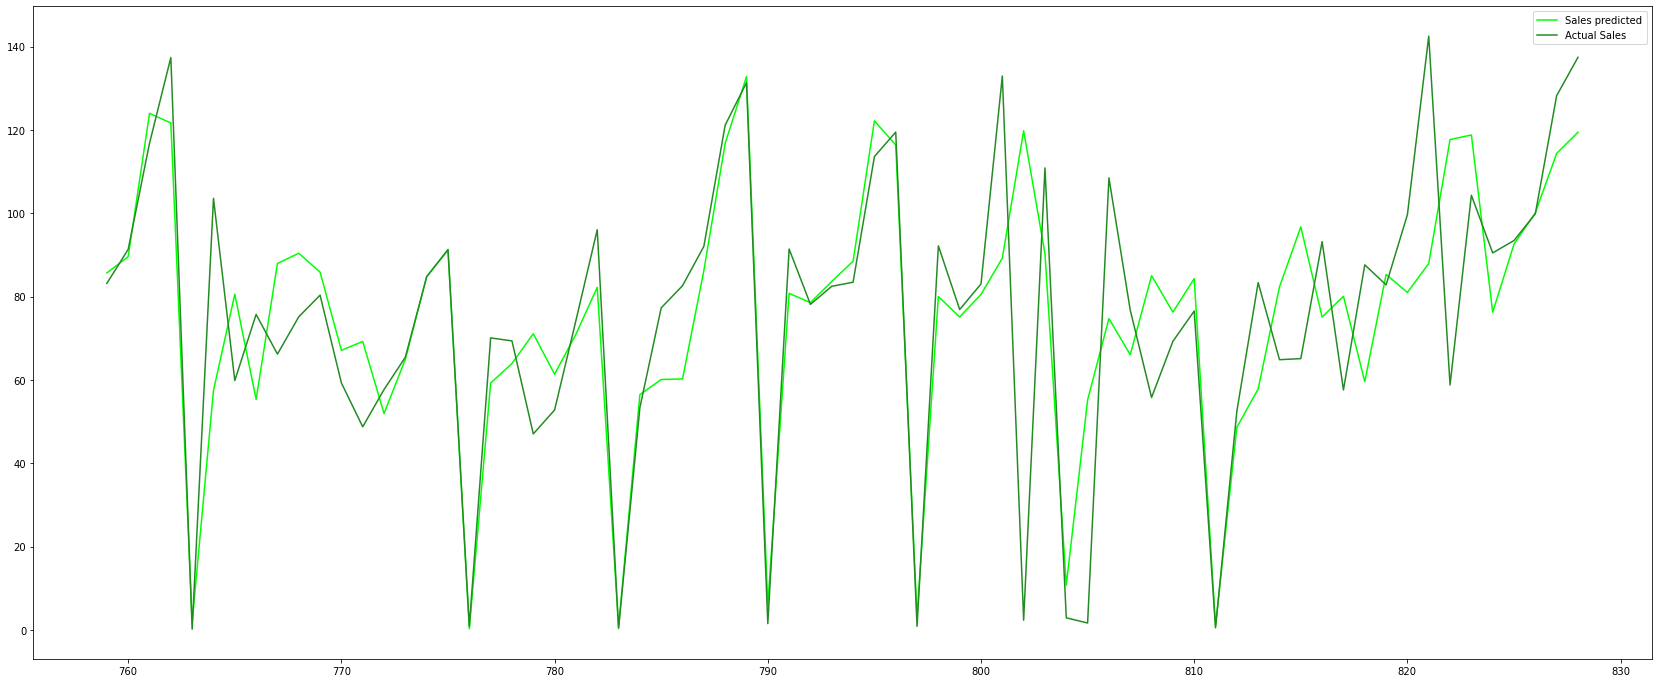

In [586]:
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=80, random_state=90), df, norma)

## Support Vector Machines (SVM):

In this case we will apply the Support Vector Machine (Regressor), which certainly have a lower performance than the Random Forest model, however, it also takes a considerable less amount of time to give us a good result. In this case we will play with the hyperparameter _C_ which is the regualation parameter of the support vector machine.

Month 759 - Error 0.21597
Month 760 - Error 0.24469
Month 761 - Error 0.32555
Month 762 - Error 0.42202
Month 763 - Error 3.63592
Month 764 - Error 0.29334
Month 765 - Error 0.21186
Month 766 - Error 0.06851
Month 767 - Error 0.12363
Month 768 - Error 0.10433
Month 769 - Error 0.07750
Month 770 - Error 0.08196
Month 771 - Error 0.33634
Month 772 - Error 0.08046
Month 773 - Error 0.00127
Month 774 - Error 0.10306
Month 775 - Error 0.12281
Month 776 - Error 3.18886
Month 777 - Error 0.08249
Month 778 - Error 0.10993
Month 779 - Error 0.27810
Month 780 - Error 0.20469
Month 781 - Error 0.03262
Month 782 - Error 0.17232
Month 783 - Error 3.31501
Month 784 - Error 0.18710
Month 785 - Error 0.21749
Month 786 - Error 0.30341
Month 787 - Error 0.33504
Month 788 - Error 0.41095
Month 789 - Error 0.39807
Month 790 - Error 2.84692
Month 791 - Error 0.18902
Month 792 - Error 0.06551
Month 793 - Error 0.14270
Month 794 - Error 0.10824
Month 795 - Error 0.28354
Month 796 - Error 0.26626
Month 797 - 

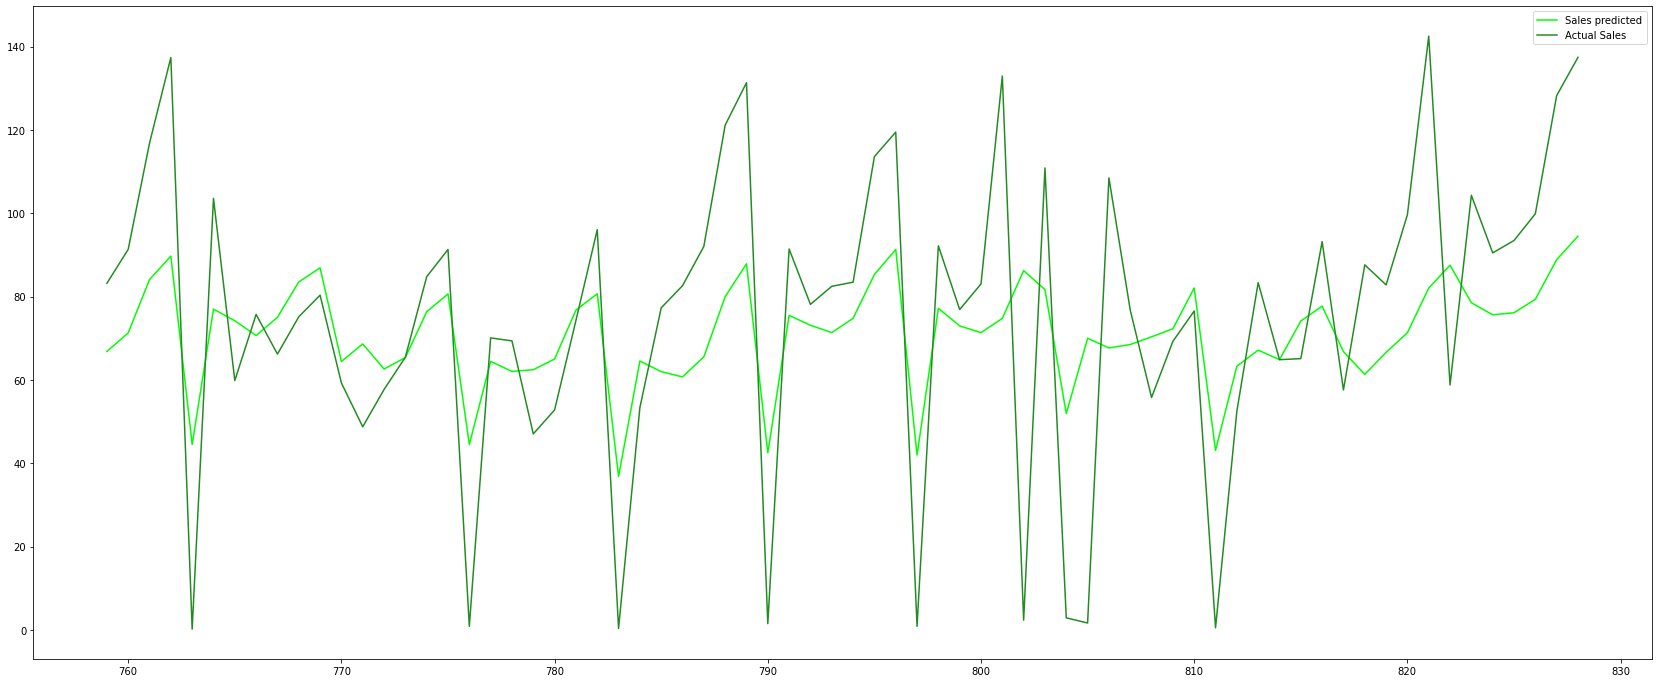

In [587]:
calculoEvaluacionModelo(SVR(C = 0.77), df, True)